In [1]:
import numpy as np
from scipy.stats import mode
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import theano
import pymc3 as pm
import lasagne
import theano.tensor as T

floatX = theano.config.floatX

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5005)


In [3]:
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.metrics import accuracy_score

In [4]:
DATA = 'MNIST'

In [5]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    mnist = fetch_mldata('MNIST original')
    data = mnist['data'].reshape((70000, 1, 28, 28)).astype(np.float32)
    target = mnist['target'].astype(np.float32)
    # We can now download and read the training and test set images and labels.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=10000)
    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print("Finished!")

Loading data...
Finished!


In [6]:
input_shape = list(X_train.shape)
input_shape[0] = None
input_shape = tuple(input_shape)
input_shape

(None, 1, 28, 28)

In [7]:
class PriorWeights(object):
    def __init__(self, mode='W', prior='gauss', **params):
        self.count = 0
        self.prior = prior
        self.mode = mode
        params.setdefault('std', 1.)
        params.setdefault('hyper', None)
        self.params = params
    def __call__(self, shape):
        self.count += 1
        if self.params['hyper'] is None:
            std = self.params['std']
        elif self.params['hyper'] == 'cauchy':
            std = pm.HalfCauchy('hyper_%s%d' % (self.mode, self.count), beta=1.)
        elif self.params['hyper'] == 'normal':
            std = pm.HalfNormal('hyper_%s%d' % (self.mode, self.count), mu=0., sd=1.)
        elif self.params['hyper'] == 'flat':
            std = pm.Flat()
        if self.prior == 'gauss':
            return pm.Normal('%s%d' % (self.mode, self.count), mu=0, sd=std, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
        elif self.prior == 'laplace': 
            return pm.Laplace('%s%d' % (self.mode, self.count), mu=0, b=std, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
        elif self.prior == 'flat':
            return pm.Flat('%s%d' % (self.mode, self.count), 
                           testval=np.random.normal(size=shape).astype(np.float64), 
                           shape=shape)

In [8]:
def build_ann(prior_b, prior_W, input_var, target_var, 
              input_shape, params=[176, 64, 10]):
    
    n_hid1, n_hid2, n_classes = params
    with pm.Model() as neural_network:
        l_in = lasagne.layers.InputLayer(shape=input_shape,
                                         input_var=input_var)
        l_conv1 = lasagne.layers.Conv2DLayer(
                            l_in, num_filters=32, filter_size=(5, 5),
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)
        
        l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))
        
        l_conv2 = lasagne.layers.Conv2DLayer(
                            l_pool1, num_filters=32, filter_size=(5, 5),
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)

        l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))

        l_dense1 = lasagne.layers.DenseLayer(
                            l_pool2, num_units=n_hid1,
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)

        l_dense2 = lasagne.layers.DenseLayer(
                            l_pool2, num_units=n_hid2,
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.tanh)

        l_out = lasagne.layers.DenseLayer(
                            l_dense2, num_units=n_classes,
                            b=prior_b, W=prior_W,
                            nonlinearity=lasagne.nonlinearities.softmax,
        )

        prediction = lasagne.layers.get_output(l_out)
        
        out = pm.Categorical('out', prediction,
                           observed=target_var,
                           total_size=y_train.shape[0])
    
    return neural_network

In [9]:
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        ixs = rng.randint(len(data), size=100)
        yield data[ixs]

In [10]:
def get_prediction(samples_proba):
    return mode(np.argmax(sample_proba(X_test, 500), 
                          axis=-1), axis=0).mode[0]

In [11]:
minibatch_X = pm.generator(create_minibatch(X_train))
minibatch_y = pm.generator(create_minibatch(y_train))
neural_network_minibatch = build_ann(PriorWeights(mode='b', prior='gauss', std=0.1), 
                                     PriorWeights(mode='W', prior='gauss', std=0.1),
                                     minibatch_X, minibatch_y, 
                                     input_shape, params=[176, 64, 10])

In [12]:
ADVI_ITERS = 80000
N_SAMPLES = 500

In [13]:
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(ADVI_ITERS, method=inference)

Average Loss = 19,106: 100%|██████████| 80000/80000 [17:30<00:00, 76.15it/s]


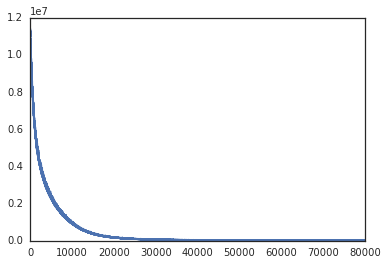

In [14]:
plt.plot(inference.hist[10:])

In [15]:
x = T.tensor4('X')
n = T.iscalar('n')
theano.config.compute_test_value = 'off'
_sample_proba = approx.sample_node(neural_network_minibatch.out.distribution.p, 
                                   size=n,
                                   more_replacements={minibatch_X:x})
prediction = approx.apply_replacements(neural_network_minibatch.out.distribution.p, 
                                    deterministic=True, 
                                    more_replacements={minibatch_X:x})

sample_proba = theano.function([x, n], _sample_proba)
map_proba = theano.function([x], prediction)

In [16]:
y_pred_MAP = np.argmax(map_proba(X_test), axis=1)
error_under_MAP = y_pred_MAP != y_test
error_rate_under_MAP = error_under_MAP.mean()

y_preds_posterior = sample_proba(X_test, 100)
y_pred_posterior = mode(np.argmax(y_preds_posterior, axis=-1), axis=0).mode[0]
error_under_posterior = y_pred_posterior != y_test
error_rate_under_posterior = error_under_posterior.mean()

In [17]:
print('MAP                      : %f' % error_rate_under_MAP)
print('predictive posterior mode: %f' % error_rate_under_posterior)

MAP                      : 0.024800
predictive posterior mode: 0.025600


In [18]:
def check_the_error_at(idx):
    print('true:', y_test[error_under_posterior][idx],'prediction:', y_pred_posterior[error_under_posterior][idx])
    plt.gray()
    plt.matshow(X_test[error_under_posterior][idx][0])
    plt.show()

In [19]:
X_test.shape

(10000, 1, 28, 28)

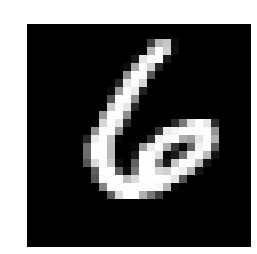

In [20]:
plt.gray()
plt.matshow(X_test[0, 0, :, :])
plt.axis('off')
plt.savefig('pic/'+DATA+'/example.png')
plt.show()

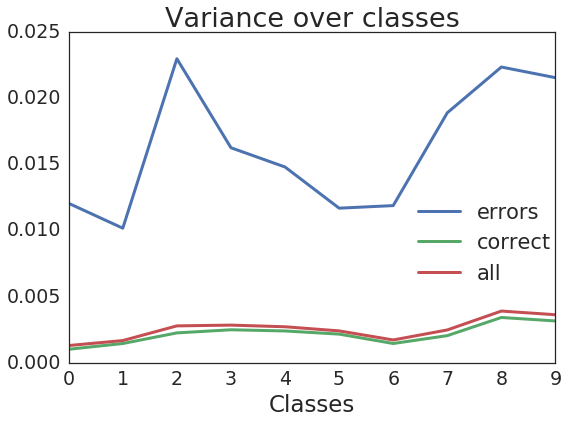

In [22]:
plt.figure(figsize=(8, 6))
plt.tick_params(axis='both', which='major', labelsize=19)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(y_preds_posterior.var(0)[error_under_posterior].mean(0), lw=3, label='errors')
plt.plot(y_preds_posterior.var(0)[~error_under_posterior].mean(0), lw=3, label='correct')
plt.plot(y_preds_posterior.var(0).mean(0), lw=3, label='all')
plt.title('Variance over classes', fontsize=27);
plt.xlabel('Classes', fontsize=23)
plt.legend(bbox_to_anchor=(0.7, 0.51), loc=2, borderaxespad=0., fontsize=21)
plt.tight_layout()
plt.savefig('pic/' + DATA + '/variance.png')

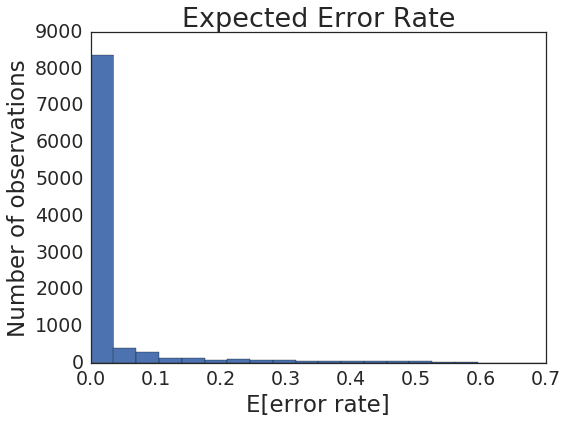

In [21]:
y_preds_labels = np.argmax(y_preds_posterior, axis=-1)
plt.figure(figsize=(8, 6))
plt.tick_params(axis='both', which='major', labelsize=19)
plt.tick_params(axis='both', which='minor', labelsize=8)
prediction_expected_error_rate = (y_preds_labels != y_pred_posterior).mean(0)
plt.hist(prediction_expected_error_rate, bins=20)
plt.title('Expected Error Rate', fontsize=27);
plt.xlabel('E[error rate]', fontsize=23)
plt.ylabel('Number of observations', fontsize=23)
plt.tight_layout()
plt.savefig('pic/' + DATA + '/eer.png')

In [22]:
((prediction_expected_error_rate != 0) == error_under_posterior).mean()

0.72529999999999994

In [23]:
(prediction_expected_error_rate[error_under_posterior] == 0).mean()

0.014150943396226415

In [24]:
(prediction_expected_error_rate[error_under_posterior] == 0).sum()

3

In [25]:
houston_we_have_a_problem = prediction_expected_error_rate[error_under_posterior] == 0

In [59]:
def problem_display():
    for i in range(houston_we_have_a_problem.sum()):
        print('true:', y_test[error_under_posterior][houston_we_have_a_problem][i],
              'prediction:', y_pred_posterior[error_under_posterior][houston_we_have_a_problem][i])
        plt.gray();plt.matshow(X_test[error_under_posterior][houston_we_have_a_problem][i][0]);
        plt.axis('off')
        plt.savefig('pic/'+DATA+'/high_conf/highconf_%d_true_%d_pred_%d.png' % (i, y_test[error_under_posterior][houston_we_have_a_problem][i],
                                                               y_pred_posterior[error_under_posterior][houston_we_have_a_problem][i]))
        plt.show();

('true:', 7.0, 'prediction:', 0)


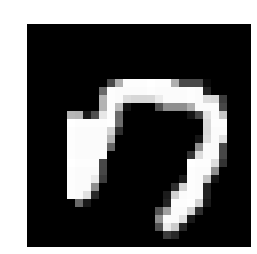

('true:', 9.0, 'prediction:', 7)


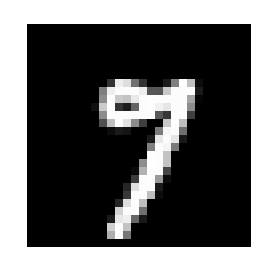

('true:', 5.0, 'prediction:', 6)


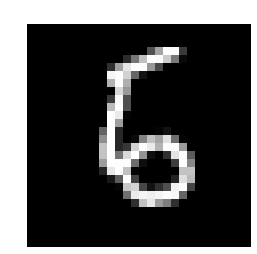

In [61]:
problem_display()

In [28]:
top_three = np.argsort(prediction_expected_error_rate)[-3:][::-1]
top_three

array([3959, 5915, 8034])

In [57]:
def low_confidence_examples_display():
    cnt = 0
    for i in top_three:
        print('true:', y_test[i],
              'prediction:', y_pred_posterior[i],
              'expected error rate:', prediction_expected_error_rate[i]
             )
        plt.gray();plt.matshow(X_test[i][0]);
        plt.axis('off')
        plt.savefig('pic/'+DATA+'/low_conf/lowconf_%d_true_%d_pred_%d_eer_%.3f.png' % (cnt, y_test[i], 
                                                              y_pred_posterior[i], 
                                                              prediction_expected_error_rate[i]))
        cnt += 1
        plt.show();

('true:', 4.0, 'prediction:', 0, 'expected error rate:', 0.69999999999999996)


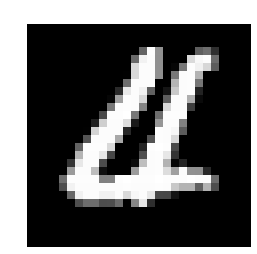

('true:', 6.0, 'prediction:', 8, 'expected error rate:', 0.69999999999999996)


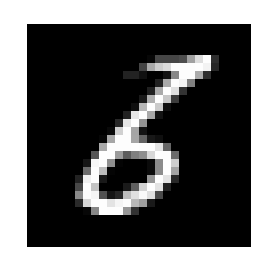

('true:', 1.0, 'prediction:', 1, 'expected error rate:', 0.69999999999999996)


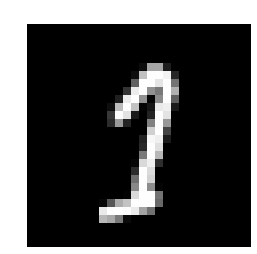

In [62]:
low_confidence_examples_display()